In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import io, transform, color, morphology
import os
from tqdm import tqdm

# Skin detection

We set the paths of the data:

In [2]:
TR_DATA = './Training-Dataset/Images/'
TR_MASKS = './Training-Dataset/Masks-Ideal/'
VAL_DATA = './Validation-Dataset/Images/'
VAL_MASKS = './Validation-Dataset/Masks-Ideal/'

In [3]:
def rgb2rg(im):
    im = im.astype('float')
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    suma = b + g + r
    im[:,:,0]=np.divide(r,suma, out=np.zeros_like(r), where=suma!=0)*254
    im[:,:,1]=np.divide(g,suma, out=np.zeros_like(g), where=suma!=0)*254
    im[:,:,2]=np.divide(b,suma, out=np.zeros_like(b), where=suma!=0)*254   
    return np.uint8(im)

In [4]:
def rgb2hsv(im):
    hsv = color.rgb2hsv(im)
    hsv = np.uint8(hsv/np.max(hsv)*254)
    
    c0_hsv = hsv[:,:,0]
    c1_hsv = hsv[:,:,1]
    c2_hsv = hsv[:,:,2]
    
    hsv[:,:,0] = c1_hsv
    hsv[:,:,1] = c0_hsv
    hsv[:,:,2] = c2_hsv
    
    return hsv

In [5]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [6]:
def apply_mask(image, mask):
    img_size = image.shape
    masked_image = np.empty(img_size)
    for i in range(img_size[2]):
        masked_image[:,:,i] = np.maximum(image[:,:,i], mask)
    masked_image = masked_image.astype("uint8")
    return masked_image

In [7]:
def bidimensional_histogram(image):
    hist = np.histogram2d(image[:,:,1].ravel(), image[:,:,2].ravel(), bins = (255, 255), range = ((0,255),(0,255)))
    hist = hist[0].astype('int')
    hist[254] = 0 # remove component 255 of the background
    return hist

In [8]:
def avg_histogram(list_hists):
    avg_hist = np.sum(list_hists, axis = 0) / len(list_hists)
    return avg_hist

In [9]:
def train_model(data_path, masks_path, color_space):
    images = []
    hists = []
    print("Reading data...")
    for file in os.listdir(data_path):
        # Ignore hidden files
        if file[0] != '.':
            #print(file)
            tr_image = io.imread(data_path + file)
            
            # Transform image to the given color space.
            if color_space == 'rg':
                tr_image = rgb2rg(tr_image)
            elif color_space == 'ycbcr':
                tr_image = rgb2ycbcr(tr_image)
            elif color_space == 'hsv':
                tr_image = rgb2hsv(tr_image)
            else:
                print("Specify a valid color space!")
                return()
            
            # Get skin parts only by using its training mask.
            file_name = os.path.splitext(file)[0]
            tr_mask = io.imread(masks_path + file_name + '.bmp')
            
            masked_image = apply_mask(tr_image, tr_mask)
            hist = bidimensional_histogram(masked_image)
            
            images.append((tr_image, tr_mask, masked_image, hist))
            hists.append(hist)
    
    n = len(images)
    print(f"{data_path} has {n} images")

    avg_hist = avg_histogram(hists)
    
    plt.imshow(avg_hist, cmap='flag')
    
    print("Skin model computed. This is its average histogram:")
    
    return avg_hist

Reading data...
./Training-Dataset/Images/ has 60 images
Skin model computed. This is its average histogram:


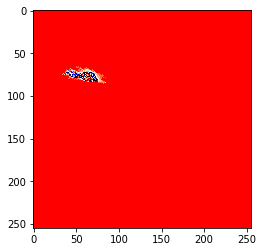

In [10]:
skin_model_rg = train_model(TR_DATA, TR_MASKS, color_space = 'rg')

Reading data...
./Training-Dataset/Images/ has 60 images
Skin model computed. This is its average histogram:


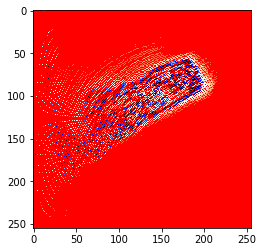

In [11]:
skin_model_hsv = train_model(TR_DATA, TR_MASKS, color_space = 'hsv')

Reading data...
./Training-Dataset/Images/ has 60 images
Skin model computed. This is its average histogram:


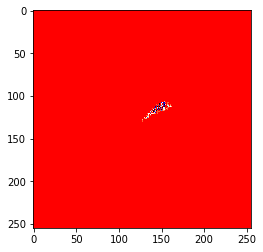

In [12]:
skin_model_ycbcr = train_model(TR_DATA, TR_MASKS, color_space = 'ycbcr')

In [13]:
def detect_skin_2d(img, hist, pct = .0):
    masked_img = np.empty(img.shape[0:2])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            a, b = img[i,j,1], img[i,j,2]
            masked_img[i,j] = hist[a,b]
    masked_img = 1 - masked_img/np.max(masked_img)
    masked_img = np.where(masked_img > pct, 1, 0)
    return masked_img

In [14]:
def improve_image(ima):
    se1 = np.ones((8,8))
    se2 = np.ones((3,3))
    
    # remove noise
    ima_ope = morphology.opening(ima, se1) ## Remove noise inside the hands (white pixels noise)
    ima_clo = morphology.closing(ima_ope, se2) ## Remove noise in the background (black pixels noise)
    
    ## HOLE FILLING
    # we apply a padding of 1px if the hand touches the border !!!
    ima_clo = np.pad(ima_clo, 1, constant_values=1)
    # we create the marker as a WHITE BORDER frame and inside black
    mar = np.zeros(((ima_clo.shape)[0]-2, (ima_clo.shape)[1]-2))
    mar = np.pad(mar, 1, constant_values=1)
    rec = morphology.reconstruction(mar, ima_clo, method='dilation')
    rec = rec[1:-1,1:-1]  ## Delete the padding we put !!
    rec = rec.astype('int')
    return rec

In [15]:
def metrics(rec, gt):
    TP = FP = FN = TN = 0
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            if rec[i,j] == 0: ## Black --> means hand
                if rec[i,j] == gt[i,j]:
                    TP += 1
                else:
                    FP += 1
            else: ## 1: White --> means background
                if rec[i,j] == gt[i,j]:
                    TN += 1
                else:
                    FN += 1
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*precision*recall/(precision+recall)
    return precision, recall, f1, TP, FP, FN, TN

In [16]:
def avg_metrics(images_list):
    n = len(images_list)
    avg_pre = avg_rec = avg_f1 = 0
    for x in images_list:
        avg_pre += x[3]
        avg_rec += x[4]
        avg_f1 += x[5]
    avg_pre /= n
    avg_rec /= n
    avg_f1 /= n
    return avg_pre, avg_rec, avg_f1

In [17]:
def sample_predictions(images_list, n = 1):
    skin_samples = np.random.randint(len(images_list), size = n)
    for img in skin_samples:
        f, axarr = plt.subplots(1,4, figsize=(12,12))
        axarr[0].imshow(images_list[img][0])
        axarr[1].imshow(images_list[img][6], cmap='gray')
        axarr[2].imshow(images_list[img][1], cmap='gray')
        axarr[3].imshow(images_list[img][2], cmap='gray')

In [18]:
def predict_skin(data_path, masks_path, skin_model, color_space = 'ycbcr', pct = .95):
    images = []
    i = 0
    # Those represent the metrics for the total
    TP_t = FP_t = FN_t = TN_t = 0
    
    for file in tqdm(os.listdir(data_path)):
        # Ignore hidden files
        if i < 999 and file[0] != '.':
            #print(file)
            ori_image = io.imread(data_path + file)
            
            if color_space == 'rg':
                te_image = rgb2rg(ori_image)
            elif color_space == 'ycbcr':
                te_image = rgb2ycbcr(ori_image)
            elif color_space == 'hsv':
                te_image = rgb2hsv(ori_image)
            
            masked_image_raw = detect_skin_2d(te_image, skin_model, pct)
            
            masked_image = improve_image(masked_image_raw)
            
            # Get ground truth mask of the current image
            file_name = os.path.splitext(file)[0]
            true_mask = (io.imread(masks_path + file_name + '.bmp') / 255).astype('int')
            
            pre, rec, f1, TP, FP, FN, TN = metrics(masked_image, true_mask)
            TP_t += TP
            FP_t += FP
            FN_t += FN
            TN_t += TN
            
            images.append((ori_image, masked_image, true_mask, pre, rec, f1, masked_image_raw))
            
            i = i + 1
      
    n = len(images)
    print(f"Predicted {n} images \n")
    
    # Those have been computed for each image, and then average each metric
    avg_pre, avg_rec, avg_f1 = avg_metrics(images)
    print(f'Average precision: {avg_pre*100:.2f} %')
    print(f'   Average recall: {avg_rec*100:.2f} %')
    print(f'  Average F-Score: {avg_f1*100:.2f} % \n')
    
    # Those represent the overall metrics of the model (for ALL images, but not independently computed)
    precision = TP_t/(TP_t+FP_t)
    recall = TP_t/(TP_t+FN_t)
    f1 = 2*precision*recall/(precision+recall)
    print(f'  Total precision: {precision*100:.2f} %')
    print(f'     Total recall: {recall*100:.2f} %')
    print(f'    Total F-Score: {f1*100:.2f} % \n')
    
    return images

In [19]:
train_images_rg = predict_skin(TR_DATA, TR_MASKS, skin_model_rg, color_space = 'rg', pct = .95)

100%|██████████| 61/61 [00:23<00:00,  2.62it/s]

Predicted 60 images 

Average precision: 88.42 %
   Average recall: 96.24 %
  Average F-Score: 91.96 % 

  Total precision: 87.63 %
     Total recall: 96.10 %
    Total F-Score: 91.67 % 



In [20]:
train_images_hsv = predict_skin(TR_DATA, TR_MASKS, skin_model_hsv, color_space = 'hsv', pct = .95)

100%|██████████| 61/61 [00:25<00:00,  2.42it/s]

Predicted 60 images 

Average precision: 69.94 %
   Average recall: 95.98 %
  Average F-Score: 78.71 % 

  Total precision: 62.86 %
     Total recall: 96.42 %
    Total F-Score: 76.10 % 



In [21]:
train_images_ycbcr = predict_skin(TR_DATA, TR_MASKS, skin_model_ycbcr, color_space = 'ycbcr', pct = .95)

100%|██████████| 61/61 [00:24<00:00,  2.53it/s]

Predicted 60 images 

Average precision: 92.70 %
   Average recall: 92.78 %
  Average F-Score: 92.51 % 

  Total precision: 91.01 %
     Total recall: 93.04 %
    Total F-Score: 92.01 % 



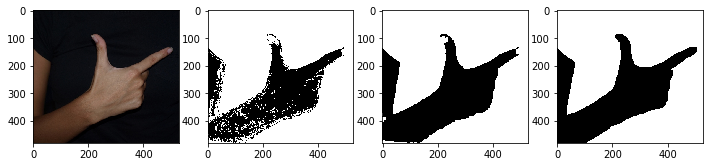

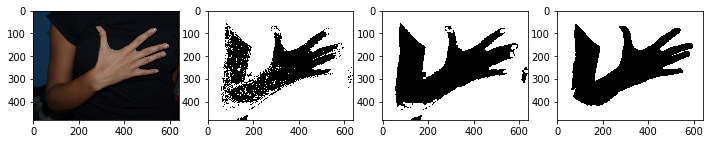

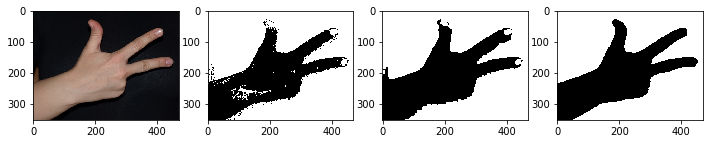

In [22]:
sample_predictions(train_images_rg, 3)

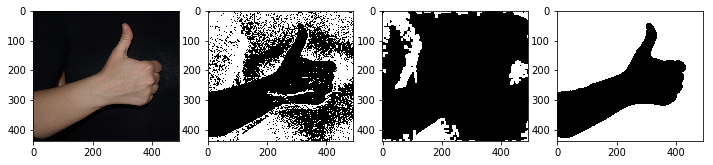

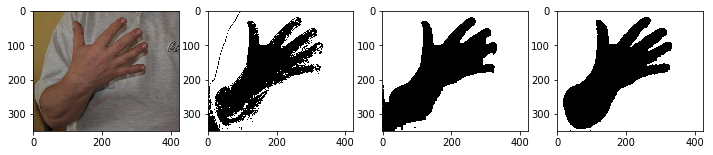

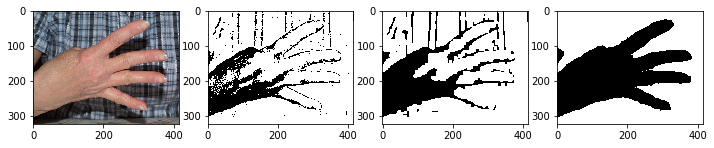

In [23]:
sample_predictions(train_images_hsv, 3)

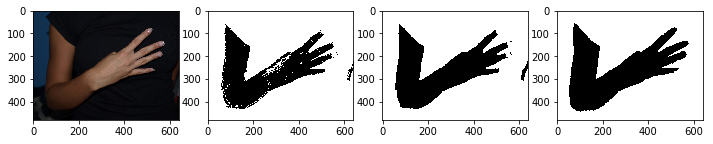

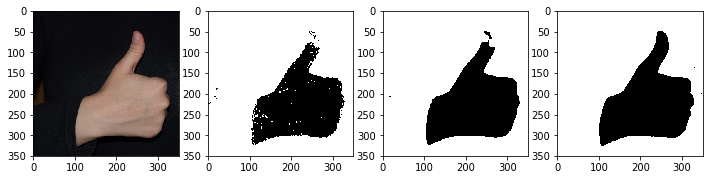

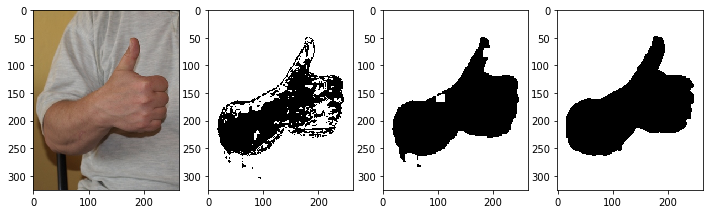

In [24]:
sample_predictions(train_images_ycbcr, 3)

In [25]:
validation_images_rg = predict_skin(VAL_DATA, VAL_MASKS, skin_model_rg, color_space = 'rg', pct = .95)

100%|██████████| 47/47 [00:27<00:00,  1.74it/s]

Predicted 46 images 

Average precision: 88.26 %
   Average recall: 85.02 %
  Average F-Score: 85.01 % 

  Total precision: 88.70 %
     Total recall: 81.47 %
    Total F-Score: 84.93 % 



In [26]:
validation_images_hsv = predict_skin(VAL_DATA, VAL_MASKS, skin_model_hsv, color_space = 'hsv', pct = .95)

100%|██████████| 47/47 [00:28<00:00,  1.64it/s]

Predicted 46 images 

Average precision: 66.07 %
   Average recall: 90.71 %
  Average F-Score: 71.87 % 

  Total precision: 52.82 %
     Total recall: 90.50 %
    Total F-Score: 66.71 % 



In [27]:
validation_images_ycbcr = predict_skin(VAL_DATA, VAL_MASKS, skin_model_ycbcr, color_space = 'ycbcr', pct = .95)

100%|██████████| 47/47 [00:27<00:00,  1.72it/s]

Predicted 46 images 

Average precision: 96.82 %
   Average recall: 91.29 %
  Average F-Score: 93.87 % 

  Total precision: 96.50 %
     Total recall: 91.39 %
    Total F-Score: 93.87 % 



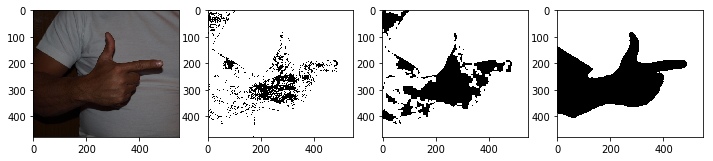

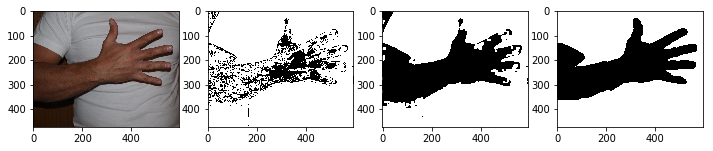

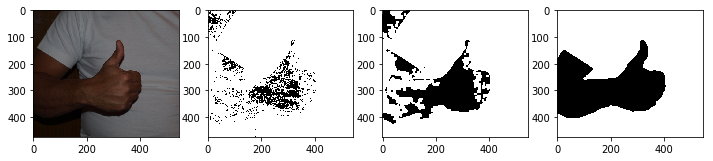

In [28]:
sample_predictions(validation_images_rg, 3)

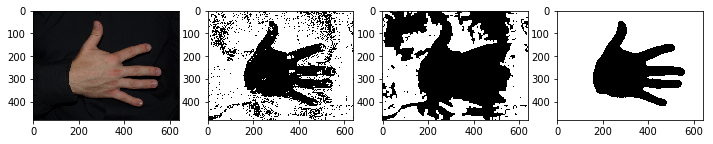

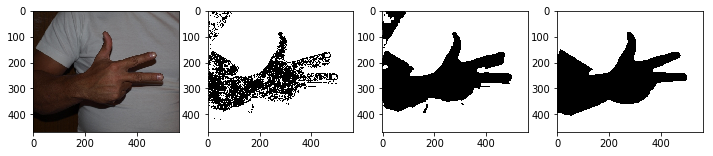

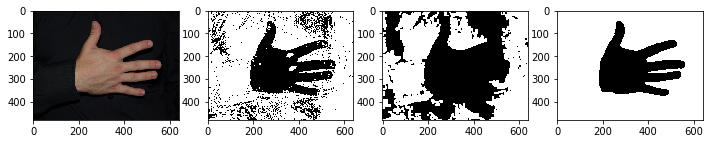

In [29]:
sample_predictions(validation_images_hsv, 3)

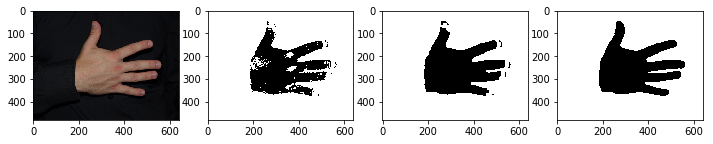

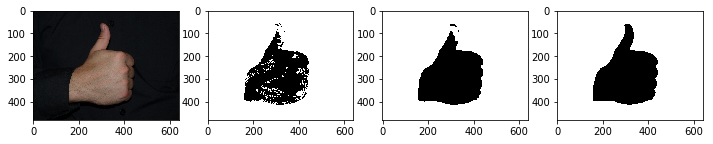

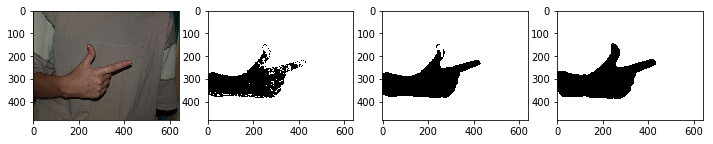

In [30]:
sample_predictions(validation_images_ycbcr, 3)

# Finger Count

In [107]:
import math
from skimage import feature

In [108]:
def dist(a, b):
    out = math.sqrt(((a[0]-b[0])**2)+((a[1]-b[1])**2))
    return out

In [144]:
def queue_creation(edges1):
    queue = []
    k=0
    found = False
    q = len(edges1)//3
    for i in range(q, len(edges1)):
        for j in range(len(edges1[0])):
            tmp = edges1[i,j]
            if tmp and not found:
                queue.append([i,j])
                found = True
            if tmp:
                k += 1
                
                
    i, j = queue[0]
    for p in range(k):
        if edges1[i, j+1] and [i, j+1] not in queue:
            i = i
            j = j + 1
            queue.append([i,j])
        elif edges1[i+1, j+1] and [i+1, j+1] not in queue:
            i = i + 1
            j = j + 1
            queue.append([i,j])
        elif edges1[i-1, j+1] and [i-1, j+1] not in queue:
            i = i - 1
            j = j + 1
            queue.append([i,j])
        elif edges1[i+1, j] and [i+1, j] not in queue:
            i = i + 1
            j = j
            queue.append([i,j])
        elif edges1[i-1, j] and [i-1, j] not in queue:
            i = i - 1
            j = j
            queue.append([i,j])
        elif edges1[i+1, j-1] and [i+1, j-1] not in queue:
            i = i + 1
            j = j - 1
            queue.append([i,j])
        elif edges1[i-1, j-1] and [i-1, j-1] not in queue:
            i = i - 1
            j = j - 1
            queue.append([i,j])
        elif edges1[i, j-1] and [i, j-1] not in queue:
            i = i
            j = j - 1
            queue.append([i,j])
            
        elif edges1[i, j+2] and [i, j+2] not in queue:
            i = i
            j = j + 2
            queue.append([i,j])
        elif edges1[i+2, j] and [i+2, j] not in queue:
            i = i + 2
            j = j
            queue.append([i,j])
        elif edges1[i-2, j] and [i-2, j] not in queue:
            i = i - 2
            j = j
            queue.append([i,j])
        elif edges1[i, j-2] and [i, j-2] not in queue:
            i = i
            j = j - 2
            queue.append([i,j])
    return queue

In [178]:
def finger_detection(dataset):
    output = []
    for file in tqdm(range(len(dataset))):        
        window = 22
        prediction = 0
        nom = file
        dits = int(dataset[file][7])
        mask = dataset[file][1]*255
        mask = Image.fromarray(mask.astype(np.uint8))
        mask_p = np.pad(mask, 10, constant_values=255)
        edge = feature.canny(mask_p)
        queue = queue_creation(edge)
        x, y = [0, 0]
        for i in range(len(queue)):
            x += queue[i][1]
            y += queue[i][0]
        x = round(x/len(queue))
        y = round(y/len(queue))

    #    edge[y, x] = True
    #    plt.imshow(edge)

        distances = []
        for i in range(len(queue)):
           distances.append(dist(queue[i],[y,x]))

        for i in range(window, len(queue)-window):
            dist_l = distances[i-window: i]
            dist_h = distances[i+1: i+window]
            if (distances[i] > max(dist_l)) and (distances[i] > max(dist_h)):
                prediction += 1
        if prediction > 5:
            prediction = 5
        output.append([file, dits, prediction])


    accuracy = 0
    real = 0
    pred = 0
    for i in range(len(output)):
        real += output[i][1]
        pred += output[i][2]
        if output[i][1] == output[i][2]:
            accuracy += 1
    accuracy = (accuracy/len(output))
    finger_accuracy = (pred/real)

    reredo = 0
    redo = 0
    reldo = 0
    for i in range(len(output)):
        if output[i][1] >= output[i][2]:
            reredo += output[i][2]
        redo += output[i][2]
        reldo += output[i][1]
    precision = reredo/redo
    recall = reredo/reldo
    f_score = 2*(precision*recall)/(precision+recall)
    return [accuracy, finger_accuracy, precision, recall, f_score]

In [179]:
val_res = finger_detection(validation_images_ycbcr)
print(f'    Hand Accuracy: {val_res[0]*100:.2f} %')
print(f'  Finger Accuracy: {val_res[1]*100:.2f} %')
print(f'Average precision: {val_res[2]*100:.2f} %')
print(f'   Average recall: {val_res[3]*100:.2f} %')
print(f'  Average F-Score: {val_res[4]*100:.2f} % \n')

100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  9.13it/s]


    Hand Accuracy: 17.39 %
  Finger Accuracy: 54.01 %
Average precision: 44.59 %
   Average recall: 24.09 %
  Average F-Score: 31.28 % 



In [234]:
train_res = finger_detection(train_images_ycbcr)
print(f'    Hand Accuracy: {train_res[0]*100:.2f} %')
print(f'  Finger Accuracy: {train_res[1]*100:.2f} %')
print(f'Average precision: {train_res[2]*100:.2f} %')
print(f'   Average recall: {train_res[3]*100:.2f} %')
print(f'  Average F-Score: {train_res[4]*100:.2f} % \n')

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  8.48it/s]


    Hand Accuracy: 23.33 %
  Finger Accuracy: 58.89 %
Average precision: 52.83 %
   Average recall: 31.11 %
  Average F-Score: 39.16 % 



In [224]:
def add_tips(img):
    im = np.zeros((len(img), len(img[0])))
    mask = img*255
    mask = Image.fromarray(mask.astype(np.uint8))
    mask_p = np.pad(mask, 10, constant_values=255)
    edge = feature.canny(mask_p)
    queue = queue_creation(edge)
    x, y = [0, 0]
    for i in range(len(queue)):
        x += queue[i][1]
        y += queue[i][0]
    x = round(x/len(queue))
    y = round(y/len(queue))

    im[y, x] = 15

    distances = []
    for i in range(len(queue)):
        distances.append(dist(queue[i],[y,x]))
        im[queue[i][0], queue[i][1]] = 5

    for i in range(window, len(queue)-window):
        dist_l = distances[i-window: i]
        dist_h = distances[i+1: i+window]
        if (distances[i] > max(dist_l)) and (distances[i] > max(dist_h)):
            im[queue[i][0], queue[i][1]] = 15
    return np.uint8(im)

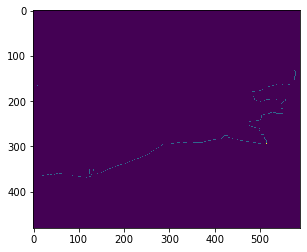

In [233]:
import pickle
im = add_tips(validation_images_ycbcr[29][1])
plt.imshow(im) #3, 20, 37
with open('image.pickle', 'wb') as handle:
    pickle.dump(im, handle, protocol=pickle.HIGHEST_PROTOCOL)